# Garcia attributes using Miranda images vs Miranda Attributes

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, random, time, MirandaAttributes, cv2
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

#Miranda dataset
train_dataset_url = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetMiranda/features_train_70000.csv"
test_dataset_url = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetMiranda/features_test_70000.csv"

#Miranda images, García attributes V1
train_dataset_urlG1 = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetStegonomonoV1/train_5000.csv"
test_dataset_urlG1 = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetStegonomonoV1/test_5000.csv"

#Miranda images, García attributes V2
train_dataset_urlG2 = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetStegonomonoV2/train_5000.csv"
test_dataset_urlG2 = "https://raw.githubusercontent.com/intentodemusico/StegianV2/master/DatasetStegonomonoV2/test_5000.csv"

TensorFlow version: 2.3.0
Eager execution: True


In [3]:
#%% Importing the dataset
MirandaLabels=['Kurtosis', 'Skewness', 'Std', 'Range', 'Median', 'Geometric_Mean', 'Mobility', 'Complexity']
trainDataset = pd.read_csv(train_dataset_url)
MirandaX_train = trainDataset.iloc[:, :-1].values
MirandaY_train = trainDataset.iloc[:, -1].values

testDataset = pd.read_csv(test_dataset_url)
MirandaX_test = testDataset.iloc[:, :-1].values
MirandaY_test = testDataset.iloc[:, -1].values

#%% Importing the dataset stegonomono V1
G1Labels=['Kurtosis', 'Skewness', 'Std', 'Range', 'Median', 'Geometric_Mean', 'Mobility', 'Complexity']
trainDataset = pd.read_csv(train_dataset_urlG1,header=None)
G1X_train = pd.DataFrame(trainDataset.iloc[:, :-2].values,columns=G1Labels)
G1Y_train = trainDataset.iloc[:, -2].values

testDataset = pd.read_csv(test_dataset_urlG1,header=None)
G1X_test = pd.DataFrame(testDataset.iloc[:, :-2].values,columns=G1Labels)
G1Y_test = testDataset.iloc[:, -2].values

#%% Importing the dataset stegonomono V2
G2Labels=['Kurtosis', 'Skewness', 'Std', 'Range', 'Median', 'Garcia_Geomean', 'Epsilon_Geomean','Mobility', 'Complexity']
trainDataset = pd.read_csv(train_dataset_urlG2,header=None)
G2X_train = pd.DataFrame(trainDataset.iloc[:, :-1].values,columns=G2Labels)
G2X_train["Kurtosis"]=[float(x[1:-1]) for x in G2X_train["Kurtosis"]]
G2Y_train = trainDataset.iloc[:, -1].values


testDataset = pd.read_csv(test_dataset_urlG2,header=None)
G2X_test = pd.DataFrame(testDataset.iloc[:, :-1].values,columns=G2Labels)
G2X_test["Kurtosis"]=[float(x[1:-1]) for x in G2X_test["Kurtosis"]]
G2Y_test = testDataset.iloc[:, -1].values

In [4]:
#%% Feature Scaling
from sklearn.preprocessing import StandardScaler

### EDA

In [5]:
pd.DataFrame(G1Y_train).describe()

,0
count,4000.000000
mean,0.500000
std,0.500063
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [6]:
pd.DataFrame(G2Y_train).describe()

,0
count,4000.000000
mean,0.500000
std,0.500063
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [7]:
G1X_train

,Kurtosis,Skewness,Std,Range,Median,Geometric_Mean,Mobility,Complexity
0,13.528070,3.428313,346.67215,2474.0,155.0,151.34135,0.389961,3.768976
1,14.178134,3.462216,348.01108,2676.0,155.5,150.71008,0.438731,3.690892
2,2.679554,1.893911,299.19614,1384.0,138.5,153.92929,0.151144,8.017585
3,2.924293,1.936686,301.38376,1475.0,129.5,153.30716,0.298413,5.996827
4,4.072080,2.250892,461.31750,1938.0,49.0,0.00000,0.083103,11.464432
...,...,...,...,...,...,...,...,...
3995,24.946789,4.806365,529.44110,3886.0,126.5,0.00000,1.065143,1.852970
3996,16.434111,2.890011,216.15149,2006.0,185.5,190.20232,0.337350,2.995154
3997,11.568215,2.730022,267.74970,2194.0,195.5,163.11760,1.292554,1.506328
3998,10.807127,2.911698,165.19333,1083.0,236.5,219.85823,0.276002,4.050163


In [8]:
G2X_train

,Kurtosis,Skewness,Std,Range,Median,Garcia_Geomean,Epsilon_Geomean,Mobility,Complexity
0,16.528069,3.428313,346.67215,2474.0,155.0,151.34135,153.80962,0.389961,3.768976
1,17.178135,3.462216,348.01108,2676.0,155.5,150.71008,153.17198,0.438731,3.690892
2,5.679555,1.893911,299.19614,1384.0,138.5,153.92929,155.4249,0.151144,8.017585
3,5.924293,1.936686,301.38376,1475.0,129.5,153.30716,154.80574,0.298413,5.996827
4,7.072080,2.250892,461.3175,1938.0,49.0,58.43951,46.029896,0.083103,11.464432
...,...,...,...,...,...,...,...,...,...
3995,27.946789,4.806365,529.4411,3886.0,126.5,106.928474,89.651695,1.065143,1.85297
3996,19.434110,2.890011,216.15149,2006.0,185.5,190.20232,191.66467,0.33735,2.995154
3997,14.568214,2.730022,267.7497,2194.0,195.5,163.1176,164.90988,1.292554,1.506328
3998,13.807127,2.911698,165.19333,1083.0,236.5,219.85823,221.03502,0.276002,4.050163


In [9]:
G1X_train.describe()

,Kurtosis,Skewness,Std,Range,Median,Geometric_Mean,Mobility,Complexity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000
mean,21.823689,3.123951,380.995970,2977.834250,147.57975,85.545011,0.574587,4.168849
std,44.873113,3.051797,284.810485,4178.229483,72.19171,84.347220,0.375456,3.080335
min,-1.643958,-0.924079,72.596810,356.000000,0.00000,0.000000,0.065049,0.907541
25%,1.143461,1.268119,218.918723,1048.000000,93.50000,0.000000,0.251230,1.961258
50%,5.159363,2.156878,299.593935,1701.000000,155.50000,91.250255,0.472978,3.166246
75%,17.597058,3.684183,437.186158,2928.500000,203.00000,166.451557,0.877861,5.375659
max,250.701118,15.891788,2931.856400,47059.000000,341.50000,245.687470,1.701823,19.831951


In [10]:
G2X_train.describe()

,Kurtosis
count,4000.000000
mean,24.823689
std,44.873113
min,1.356042
25%,4.143461
50%,8.159363
75%,20.597057
max,253.701130


##### Dataset looks homogeneous

#### Standard scalling

In [11]:
scG1=StandardScaler()
sc_Garcia1X_train=pd.DataFrame(scG1.fit_transform(G1X_train),columns=G1Labels)
sc_Garcia1X_test=pd.DataFrame(scG1.transform(G1X_test),columns=G1Labels)

scG2=StandardScaler()
sc_Garcia2X_train=pd.DataFrame(scG2.fit_transform(G2X_train),columns=G2Labels)
sc_Garcia2X_test=pd.DataFrame(scG2.transform(G2X_test),columns=G2Labels)

scM=StandardScaler()
sc_MirandaX_train=pd.DataFrame(scM.fit_transform(MirandaX_train),columns=MirandaLabels)
sc_MirandaX_test=pd.DataFrame(scM.transform(MirandaX_test),columns=MirandaLabels)

#### Recursive Feature Elimination

In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logregRFEG1 = LogisticRegression()
rfe = RFE(logregRFEG1, n_features_to_select=1)
rfe = rfe.fit(sc_Garcia1X_train,G1Y_train)
print(rfe.ranking_)
print("García's Dataset V1")
print("Ordered from most to less desired variables:")
desiredVariables=G1Labels
sortOrder=rfe.ranking_
sorted(desiredVariables,key=lambda pos: sortOrder[desiredVariables.index(pos)])

[7 4 3 2 5 8 1 6]
García's Dataset V1
Ordered from most to less desired variables:


['Mobility',
 'Range',
 'Std',
 'Skewness',
 'Median',
 'Complexity',
 'Kurtosis',
 'Geometric_Mean']

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logregRFEG2 = LogisticRegression()
rfe = RFE(logregRFEG2, n_features_to_select=1)
rfe = rfe.fit(sc_Garcia2X_train,G2Y_train)
print(rfe.ranking_)
print("García's Dataset V2")
print("Ordered from most to less desired variables:")
desiredVariables=G2Labels
sortOrder=rfe.ranking_
sorted(desiredVariables,key=lambda pos: sortOrder[desiredVariables.index(pos)])

[6 4 3 2 8 9 5 1 7]
García's Dataset V2
Ordered from most to less desired variables:


['Mobility',
 'Range',
 'Std',
 'Skewness',
 'Epsilon_Geomean',
 'Kurtosis',
 'Complexity',
 'Median',
 'Garcia_Geomean']

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logregRFEM = LogisticRegression()
rfe = RFE(logregRFEM, n_features_to_select=1)
rfe = rfe.fit(sc_MirandaX_train,MirandaY_train)
print(rfe.ranking_)
print("Miranda's Dataset")
print("Ordered from most to less desired variables:")
desiredVariables=MirandaLabels
sortOrder=rfe.ranking_
sorted(desiredVariables,key=lambda pos: sortOrder[desiredVariables.index(pos)])

[4 3 5 6 7 8 2 1]
Miranda's Dataset
Ordered from most to less desired variables:


['Complexity',
 'Mobility',
 'Skewness',
 'Kurtosis',
 'Std',
 'Range',
 'Median',
 'Geometric_Mean']

RFE Shows prefferences for the variables to be predictors, meaning it to be ordered depending on de predictor-likability of a variable. Proving the anterior analysis, 

### Modelling

In [15]:
import statsmodels.api as sm
logit_model=sm.Logit(MirandaY_train,sc_MirandaX_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.264509
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.618     
Dependent Variable: y                AIC:              29640.4288
Date:               2021-09-07 10:38 BIC:              29711.8935
No. Observations:   55999            Log-Likelihood:   -14812.   
Df Model:           7                LL-Null:          -38816.   
Df Residuals:       55991            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Kurtosis         -0.7686   0.0737 -10.4343 0.0000 -0.9129 -0.6242
Skewness          1.0767   0.0673  15.9897 0.0000  0.9447  1.2087


In [16]:
import statsmodels.api as sm
logit_modelG1=sm.Logit(G1Y_train,sc_Garcia1X_train)
result=logit_modelG1.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.340509
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.509    
Dependent Variable: y                AIC:              2740.0695
Date:               2021-09-07 10:38 BIC:              2790.4219
No. Observations:   4000             Log-Likelihood:   -1362.0  
Df Model:           7                LL-Null:          -2772.6  
Df Residuals:       3992             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Kurtosis          0.0271   0.2484  0.1090 0.9132 -0.4597  0.5138
Skewness         -0.9426   0.2328 -4.0493 0.0001 -1.3988 -0.4863
Std          

In [17]:
import statsmodels.api as sm
logit_modelG2=sm.Logit(G2Y_train,sc_Garcia2X_train)
result=logit_modelG2.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.338752
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.511    
Dependent Variable: y                AIC:              2728.0122
Date:               2021-09-07 10:38 BIC:              2784.6586
No. Observations:   4000             Log-Likelihood:   -1355.0  
Df Model:           8                LL-Null:          -2772.6  
Df Residuals:       3991             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Kurtosis         -0.0594   0.2533 -0.2345 0.8146 -0.5558  0.4370
Skewness         -0.8707   0.2367 -3.6783 0.0002 -1.3347 -0.4068
Std          

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(newX), y, test_size=0.2, random_state=0)
logregMiranda = LogisticRegression()
logregMiranda.fit(sc_MirandaX_train, MirandaY_train)
y_predMiranda = logregMiranda.predict(sc_MirandaX_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregMiranda.score(sc_MirandaX_test, MirandaY_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [19]:
logregGarcia1 = LogisticRegression()
logregGarcia1.fit(sc_Garcia1X_train, G1Y_train)
y_predGarcia1 = logregGarcia1.predict(sc_Garcia1X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregGarcia1.score(sc_Garcia1X_test, G1Y_test)))
print(metrics.f1_score(G1Y_test,y_predGarcia1))

Accuracy of logistic regression classifier on test set: 0.86
0.8571428571428571


In [20]:
logregGarcia2 = LogisticRegression()
logregGarcia2.fit(sc_Garcia2X_train, G2Y_train)
y_predGarcia2 = logregGarcia2.predict(sc_Garcia2X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregGarcia2.score(sc_Garcia2X_test, G2Y_test)))
print(metrics.f1_score(G2Y_test,y_predGarcia2))

Accuracy of logistic regression classifier on test set: 0.86
0.8553590010405827


In [21]:
from itertools import chain, combinations
from sklearn.model_selection import cross_val_score
import copy
def best_subset_cv(estimator, X, Y, labels,cv=3):
    n_features = X.shape[1]
    subsets = chain.from_iterable([combinations(labels, k + 1) for k in range(n_features)])
    best_score = -np.inf
    best_subset = None
    for subset in subsets:
        estimatorCopy=copy.copy(estimator)
        score = cross_val_score(estimatorCopy, X.loc[:, list(subset)], Y, cv=cv).mean()
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score

In [22]:
logregBSM = LogisticRegression()
subM, scoM=best_subset_cv(logregBSM,sc_MirandaX_train,MirandaY_train,MirandaLabels)
print("Miranda")

Miranda


In [23]:
subM, scoM

(('Skewness', 'Geometric_Mean', 'Complexity'), 0.8934098557840381)

In [24]:
logregBSG1 = LogisticRegression()
subG1, scoG1=best_subset_cv(logregBSG1,sc_Garcia1X_train,G1Y_train,G1Labels)
print("García V1")

García V1


In [25]:
subG1, scoG1

(('Skewness',
  'Std',
  'Range',
  'Median',
  'Geometric_Mean',
  'Mobility',
  'Complexity'),
 0.830550216264711)

In [26]:
logregBSG2 = LogisticRegression()
subG2, scoG2=best_subset_cv(logregBSG2,sc_Garcia2X_train,G2Y_train,G2Labels)
print("García V2")

García V2


In [27]:
subG2, scoG2

(('Skewness',
  'Std',
  'Range',
  'Median',
  'Garcia_Geomean',
  'Epsilon_Geomean',
  'Mobility',
  'Complexity'),
 0.8333003415771484)

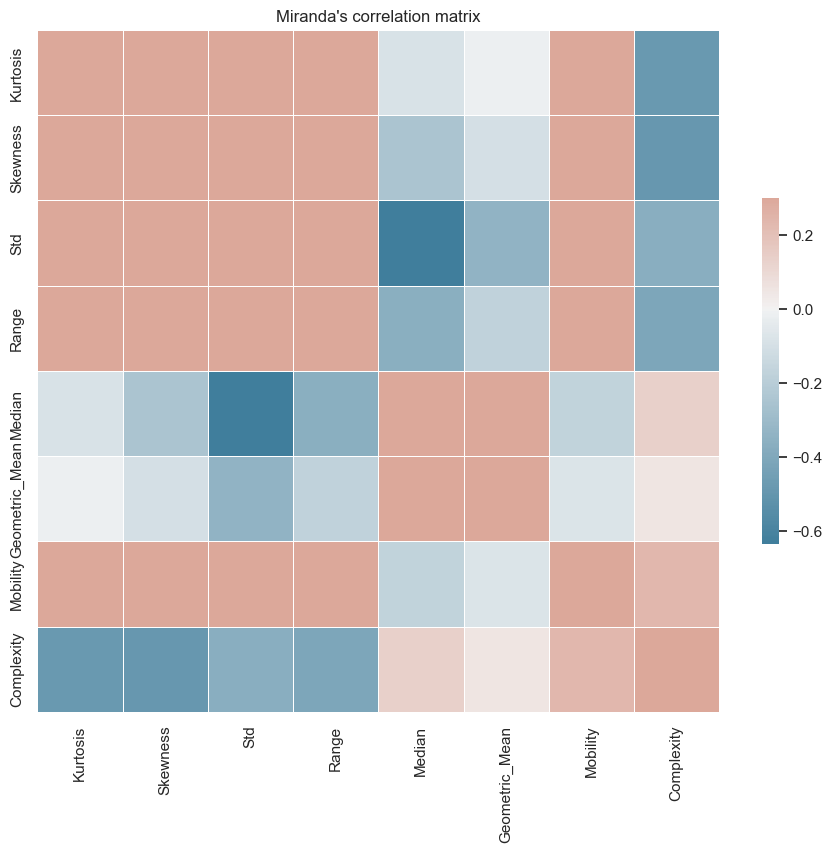

In [28]:
import seaborn as sns
sns.set_theme(style="dark")
corr = sc_MirandaX_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.tick_params(axis='x', rotation=90)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Miranda's correlation matrix")
plt.show()

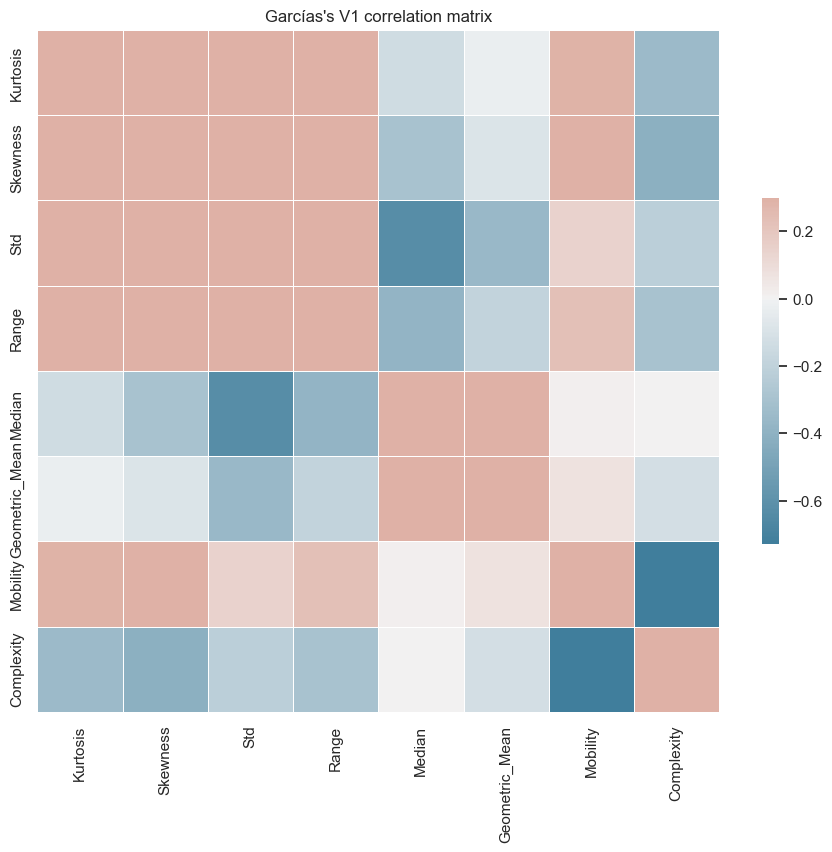

In [29]:
sns.set_theme(style="dark")
corr = sc_Garcia1X_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.tick_params(axis='x', rotation=90)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Garcías's V1 correlation matrix")
plt.show()

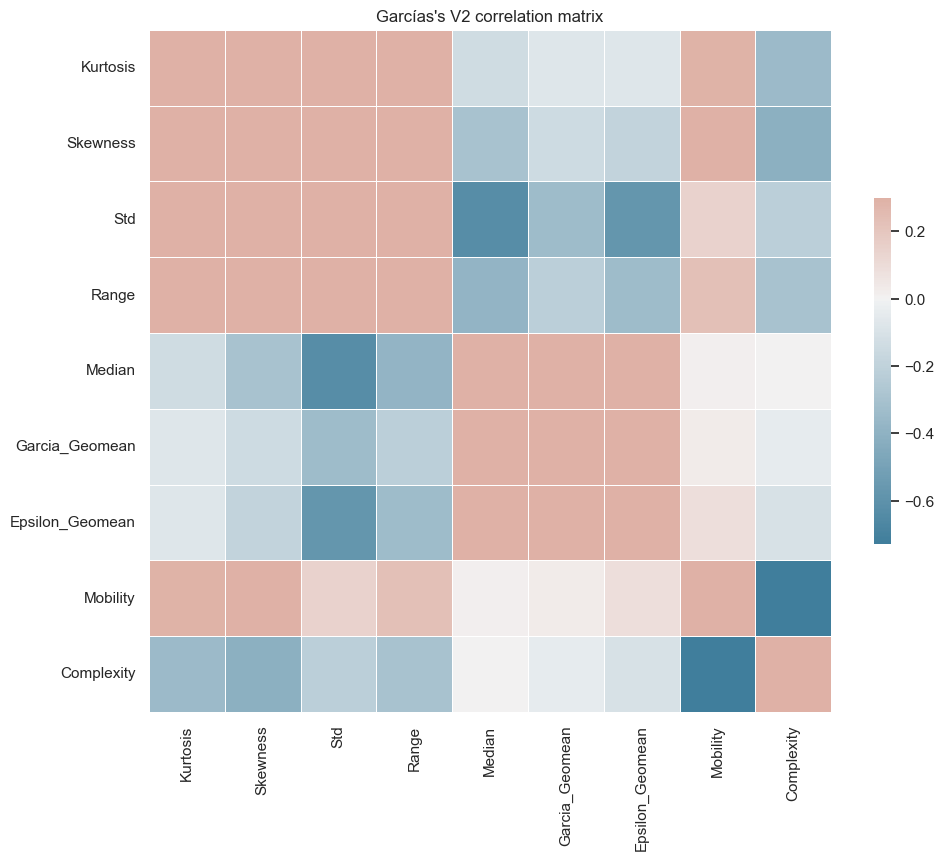

In [30]:
sns.set_theme(style="dark")
corr = sc_Garcia2X_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.tick_params(axis='x', rotation=90)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Garcías's V2 correlation matrix")
plt.show()

In [66]:
columns=x.columns.values

In [41]:
MiranData={MirandaLabels[i]:logregMiranda.coef_[0][i] for i in range(len(MirandaLabels))}

In [46]:
MiranData.values()

dict_values([-0.8207279951288443, 1.2210303130389784, 0.7769149082077331, -0.7159139235890969, 0.06174322051910646, -0.024454079362701976, 1.644385178923032, 2.612464126278875])

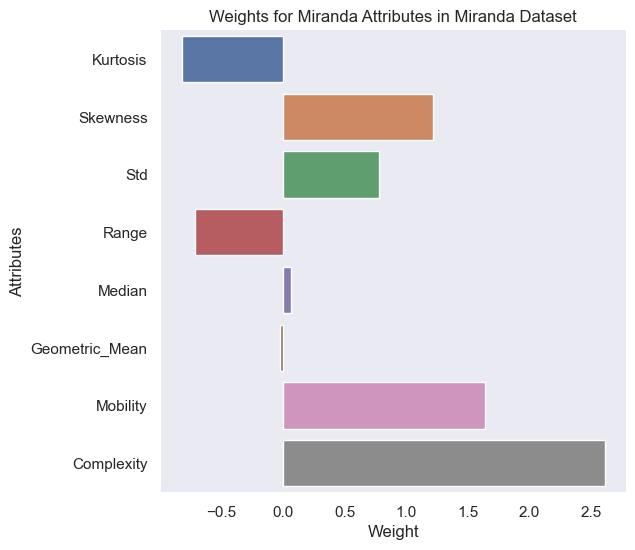

In [61]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=MirandaLabels,x=logregMiranda.coef_[0])
ax.set( xlabel="Weight",
      ylabel ="Attributes", title="Weights for Miranda Attributes in Miranda Dataset")
sns.despine(left=True, bottom=True)
plt.show()

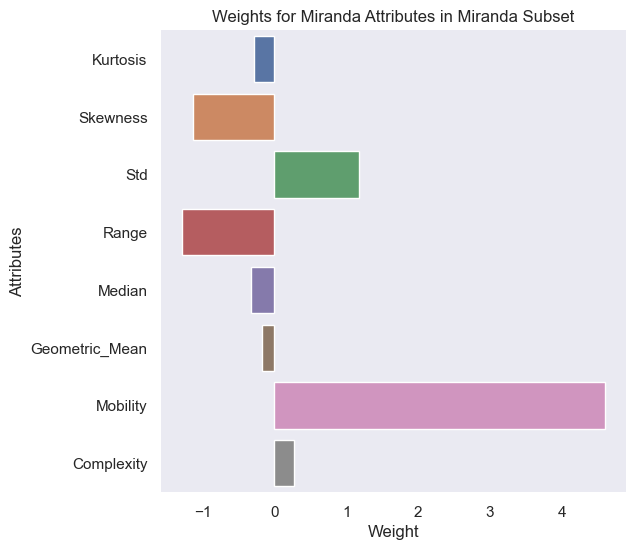

In [62]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=G1Labels,x=logregGarcia1.coef_[0])
ax.set( xlabel="Weight",
      ylabel ="Attributes", title="Weights for Miranda Attributes in Miranda Subset")
sns.despine(left=True, bottom=True)
plt.show()

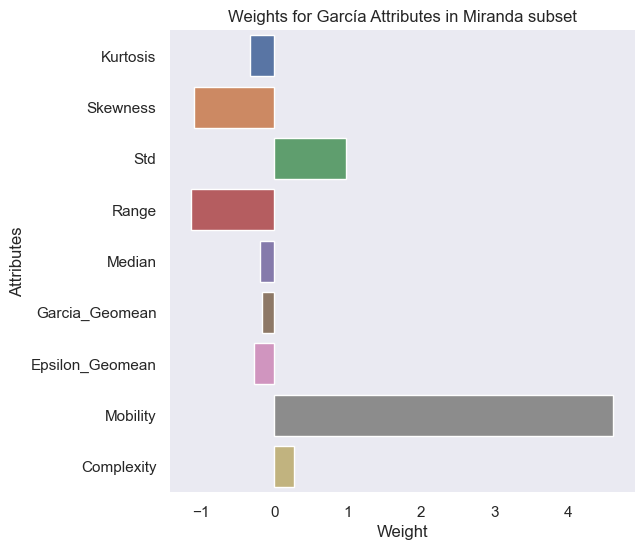

In [63]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=G2Labels,x=logregGarcia2.coef_[0])
ax.set( xlabel="Weight",
      ylabel ="Attributes", title="Weights for García Attributes in Miranda subset")
sns.despine(left=True, bottom=True)
plt.show()

In [64]:
logregGarcia2.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [65]:
logregMiranda.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}